In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from collections import OrderedDict, Counter
import collections
from pprint import pprint
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import random
import json
import re
import os
import pickle
import warnings
warnings.filterwarnings('ignore')


# import matplotlib.pyplot as plt


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# WANDB_INTEGRATION = True
# if WANDB_INTEGRATION:
#     import wandb
#     wandb.login()


/opt/anaconda3/envs/olivia_base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torchvision.transforms as T
from torchvision.models import resnet50
from torch import nn
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

torch.set_grad_enabled(False)


## Object Relateness 

In [4]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


In [5]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


In [6]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [7]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled


In [8]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval()


DETRdemo(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [9]:

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, detr, transform)


cat: 1.00
remote: 1.00
cat: 1.00
couch: 0.73
remote: 0.97


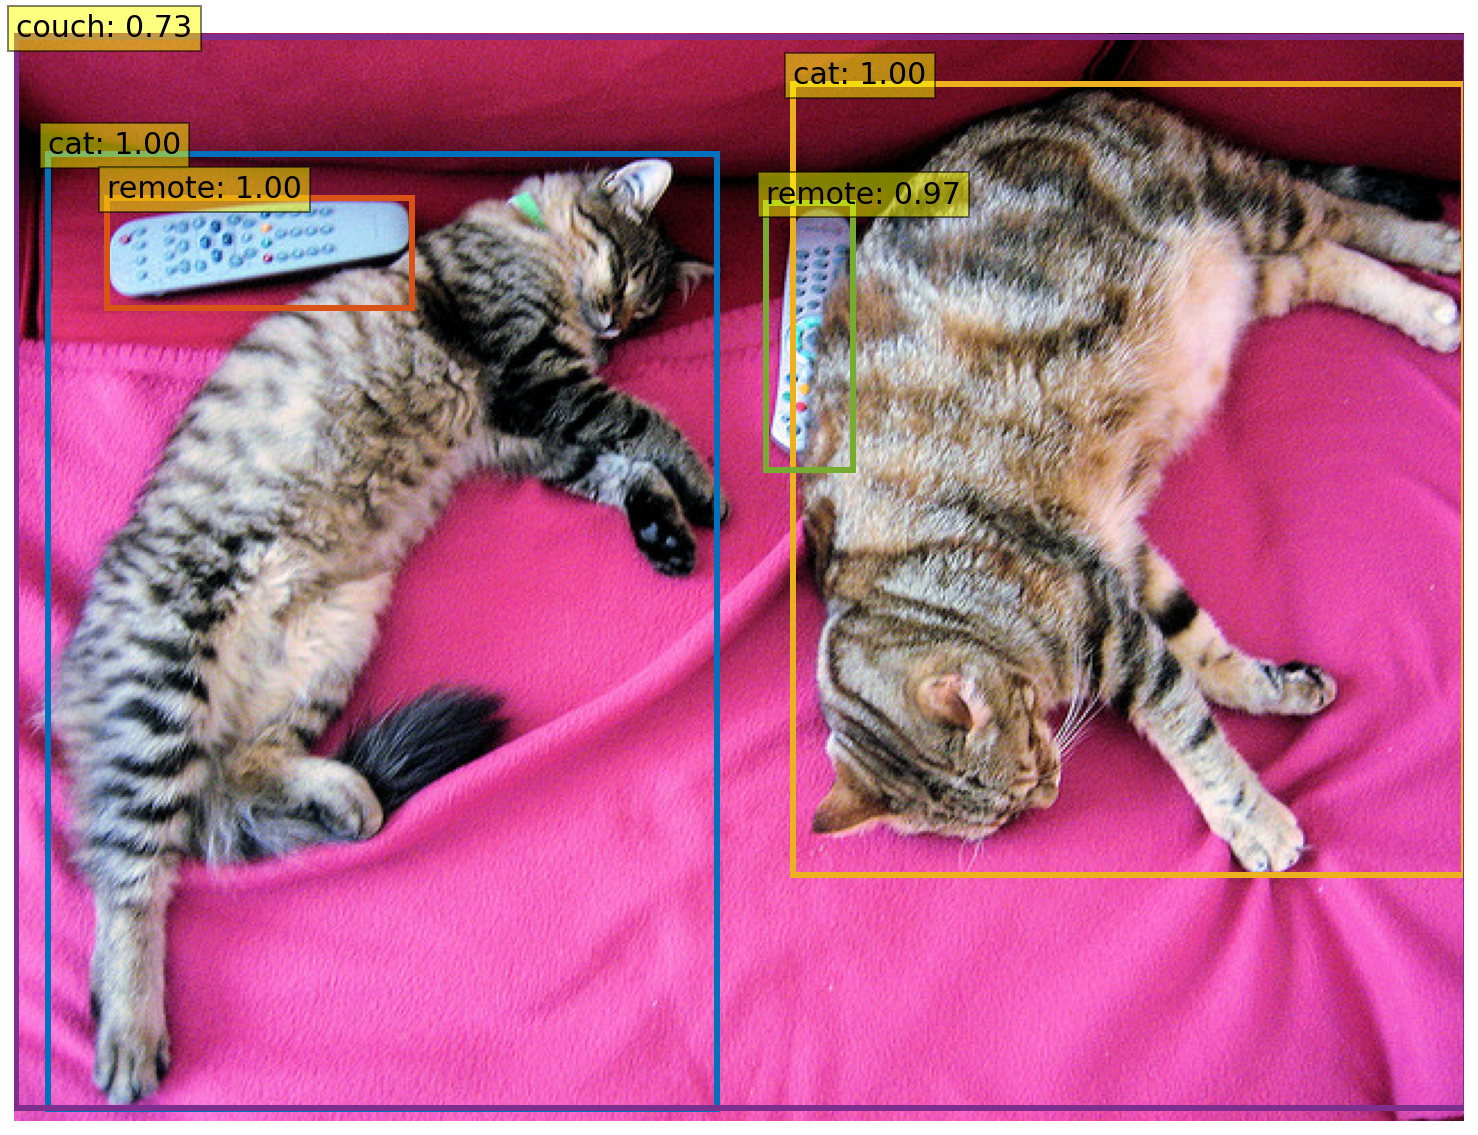

In [10]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        print(text)
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


plot_results(im, scores, boxes)


In [32]:
import torchvision.transforms as T
from torchvision.models import resnet50
from torch import nn
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'retina'
# import argparse
import os

torch.set_grad_enabled(False)

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """

    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}


def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled


detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval()


def plot_results(pil_img, prob, boxes, save_path=None):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    if save_path is None:
        if not os.path.exists("./obj_scored_images/"):
            os.mkdir("./obj_scored_images/")
        img_num = len(os.listdir("./obj_scored_images/"))
        save_path = f"./obj_scored_images/img_{img_num}.png"
    plt.savefig(save_path)
    print(f"The scored image is saved at {save_path}")
    plt.show()


def get_obj_result(img_path=None,
                   model_path='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
                   plot=False,
                   transform=transform, ):
    if img_path is None:
        print("==== DEMO Mode ====")
        img_path = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    im = Image.open(requests.get(img_path, stream=True).raw)
    scores, boxes = detect(im, detr, transform)
    if plot:
        plot_results(im, scores, boxes)
    return scores, boxes


#########################################################################
# Prepare Parser
##########################################################################


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_path', required=False, default=None,
#                         help='input image path')
#     parser.add_argument('--plot', type=bool, required=False, default=False,
#                         help='whether plot the image with detected objects')

#     args = parser.parse_args()
#     get_obj_result(args.img_path, args.model_path, args.plot)


==== DEMO Mode ====
The scored image is saved at ./obj_scored_images/img_3.png


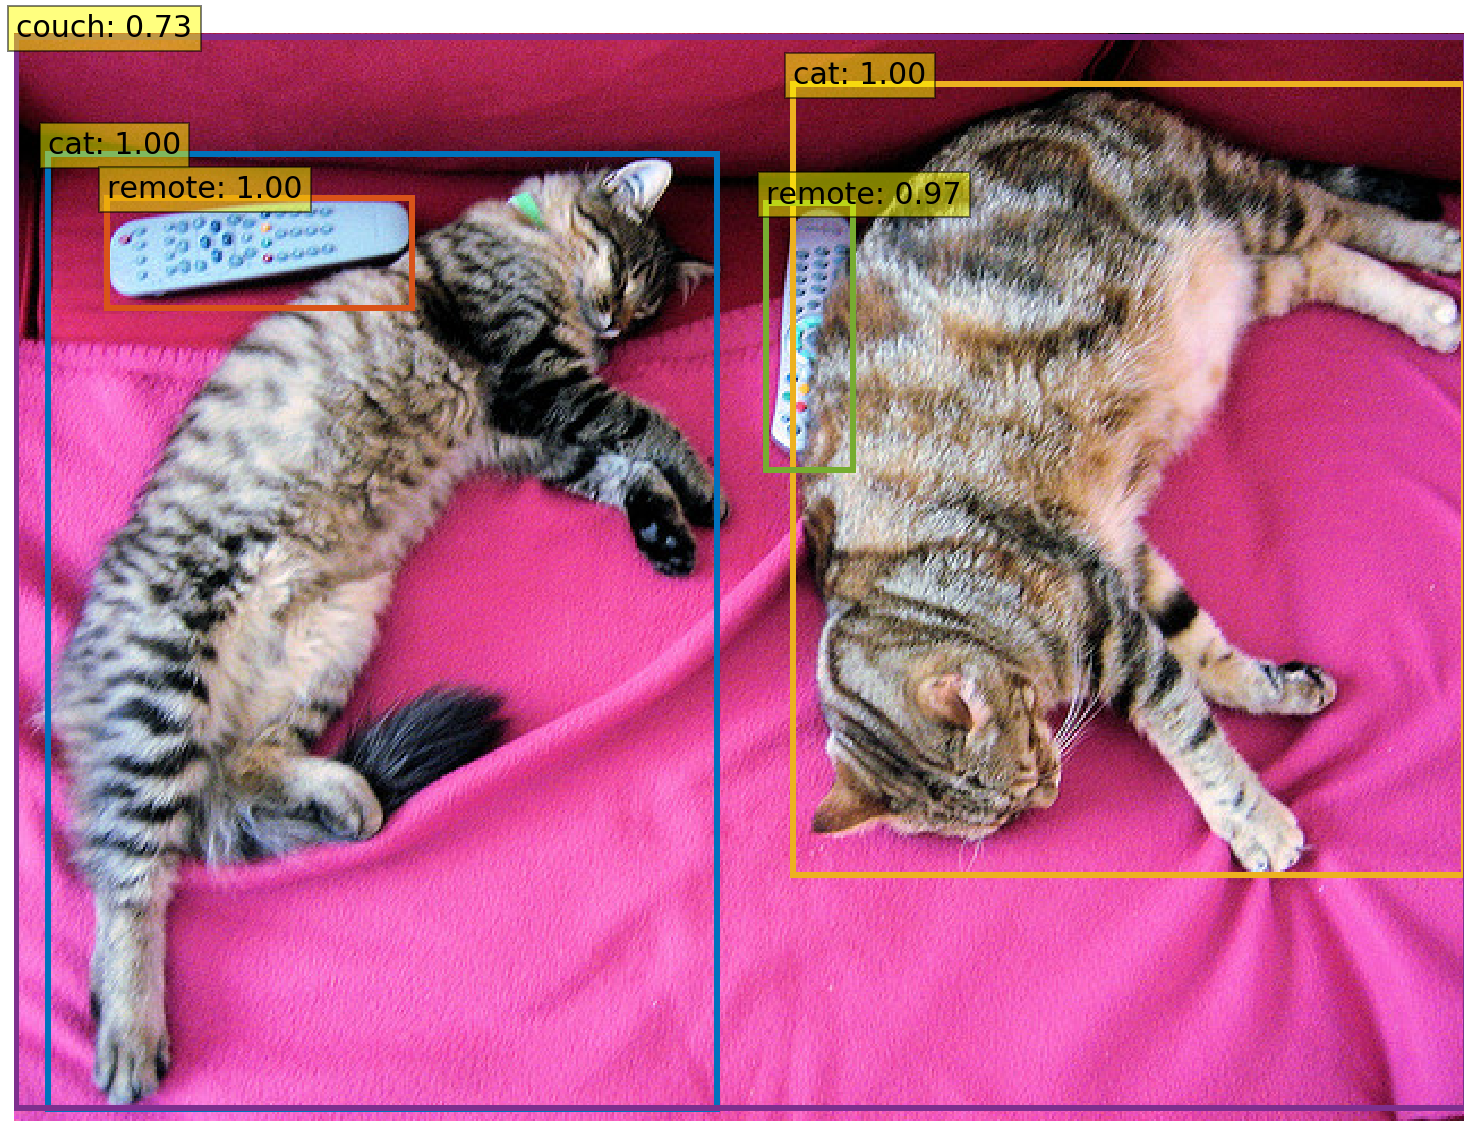

(tensor([[9.3258e-12, 3.9835e-05, 1.2076e-10, 6.0267e-09, 3.6825e-09, 3.3015e-08,
          2.4854e-12, 2.4963e-09, 1.1988e-08, 1.2165e-11, 3.2585e-09, 2.1805e-08,
          7.7568e-12, 3.2640e-11, 2.1321e-08, 5.8303e-08, 2.6795e-05, 9.9767e-01,
          2.4542e-04, 8.3998e-10, 1.7252e-07, 2.7358e-07, 5.7316e-07, 5.5908e-06,
          2.6841e-05, 1.0291e-08, 1.1717e-11, 3.0885e-07, 1.9668e-11, 8.1391e-12,
          1.0973e-11, 1.7848e-07, 1.0780e-08, 6.1135e-07, 5.0391e-11, 1.3005e-09,
          1.0852e-07, 1.9537e-10, 8.6607e-11, 4.8292e-10, 3.8045e-10, 2.3101e-08,
          1.4360e-10, 5.9996e-12, 2.1270e-05, 8.3089e-12, 5.8261e-11, 2.1842e-07,
          1.7976e-08, 2.9958e-08, 1.3691e-08, 6.5170e-08, 2.0744e-10, 4.4708e-09,
          4.6316e-08, 5.2503e-09, 6.4616e-11, 4.8704e-07, 3.4992e-07, 3.8520e-10,
          1.7668e-09, 2.2984e-10, 3.3905e-08, 1.2054e-05, 6.8885e-09, 5.9989e-07,
          1.4283e-11, 3.9168e-08, 1.1338e-11, 9.3310e-12, 3.2707e-07, 1.1324e-11,
          7.1242

In [33]:
get_obj_result(plot=True)


## Aethestic Assessment

In [5]:
import torch
from samp_net import SAMPNet
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
from PIL import Image
import os
import json
import torchvision.transforms as transforms
import random
import numpy as np
from config import Config
import cv2
IMAGE_NET_MEAN = [0.485, 0.456, 0.406]
IMAGE_NET_STD = [0.229, 0.224, 0.225]

random.seed(1)
torch.manual_seed(1)
cv2.setNumThreads(0)


In [4]:
x = torch.randn(2, 3, 224, 224)
s = torch.randn(2, 1, 224, 224)
cfg = Config()
model = SAMPNet(cfg)
weight, attribute, score = model(x, s)
if weight is not None:
    print('weight', weight.shape, F.softmax(weight, dim=1))
if attribute is not None:
    print('attribute', attribute.shape, attribute)
print('score', score.shape, score)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/oliviaaa/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 28.1MB/s]


Saliency-aware Multi-Pattern Pooling pattern: [1, 2, 3, 4, 5, 6, 7, 8], fusion manner: sum, dropout: 0.5
weight torch.Size([2, 8]) tensor([[0.0439, 0.2677, 0.1091, 0.1653, 0.0969, 0.0583, 0.1612, 0.0978],
        [0.0055, 0.2438, 0.0399, 0.1449, 0.0068, 0.1060, 0.4137, 0.0393]],
       grad_fn=<SoftmaxBackward0>)
attribute torch.Size([2, 6]) tensor([[-0.0066, -0.2639, -0.4457,  0.0507, -0.1026,  0.2647],
        [ 0.0171, -0.5814,  0.2121, -0.2071,  0.0333,  0.5283]],
       grad_fn=<MmBackward0>)
score torch.Size([2, 5]) tensor([[0.1977, 0.1982, 0.2014, 0.1997, 0.2031],
        [0.1953, 0.2026, 0.2019, 0.1948, 0.2053]], grad_fn=<SoftmaxBackward0>)


In [6]:
# Refer to: Saliency detection: A spectral residual approach
def detect_saliency(img, scale=6, q_value=0.95, target_size=(224, 224)):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    W, H = img_gray.shape
    img_resize = cv2.resize(
        img_gray, (H // scale, W // scale), interpolation=cv2.INTER_AREA)

    myFFT = np.fft.fft2(img_resize)
    myPhase = np.angle(myFFT)
    myLogAmplitude = np.log(np.abs(myFFT) + 0.000001)
    myAvg = cv2.blur(myLogAmplitude, (3, 3))
    mySpectralResidual = myLogAmplitude - myAvg

    m = np.exp(mySpectralResidual) * \
        (np.cos(myPhase) + complex(1j) * np.sin(myPhase))
    saliencyMap = np.abs(np.fft.ifft2(m)) ** 2
    saliencyMap = cv2.GaussianBlur(saliencyMap, (9, 9), 2.5)
    saliencyMap = cv2.resize(saliencyMap, target_size,
                             interpolation=cv2.INTER_LINEAR)
    threshold = np.quantile(saliencyMap.reshape(-1), q_value)
    if threshold > 0:
        saliencyMap[saliencyMap > threshold] = threshold
        saliencyMap = (saliencyMap - saliencyMap.min()) / threshold
    # for debugging
    # import matplotlib.pyplot as plt
    # plt.subplot(1,2,1)
    # plt.imshow(img)
    # plt.axis('off')
    # plt.subplot(1,2,2)
    # plt.imshow(saliencyMap, cmap='gray')
    # plt.axis('off')
    # plt.show()
    return saliencyMap


In [9]:
img_transformer = transforms.Compose([
    transforms.Resize((cfg.image_size, cfg.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD)
])


In [19]:
def get_img(image_file):
    src = Image.open(image_file).convert('RGB')
    im = img_transformer(src)

    src_im = np.asarray(src).copy()
    sal_map = detect_saliency(src_im, target_size=(
        cfg.image_size, cfg.image_size))
    sal_map = torch.from_numpy(sal_map.astype(np.float32)).unsqueeze(0)

    return torch.unsqueeze(im, 0), torch.unsqueeze(sal_map, 0)


def dist2ave(pred_dist):
    pred_score = torch.sum(
        pred_dist * torch.Tensor(range(1, 6)).to(pred_dist.device), dim=-1, keepdim=True)
    return pred_score


In [35]:
### FINAL FUNCTION ###
def assess_img(image_file_path):
    im, sal = get_img(image_file_path)
    weight, attribute, output_score = model(sample_im, sample_map)
    # if weight is not None:
    #     print('weight', weight.shape, F.softmax(weight, dim=1))
    # if attribute is not None:
    #     print('attribute', attribute.shape, attribute) 
    pred_score = dist2ave(output_score)
    pred_score = np.round(pred_score.squeeze().item(), 4)
    print('Final Score => ', pred_score)
    
    return {
        "raw_image": im.squeeze().detach().numpy(),
        "saliency_map": sal.squeeze().detach().numpy(),
        "pattern_weights": weight.squeeze().detach().numpy(),
        "final score": pred_score}


In [36]:
sample_img_path = "/home/oliviaaa/VE441/raw_images/000000039769.jpg"
assess_img(sample_img_path)

Final Score =>  2.9908


{'raw_image': array([[[ 0.31381115,  0.43368444,  0.46793392, ..., -0.35405433,
          -0.33692956, -0.33692956],
         [ 0.3651854 ,  0.43368444,  0.46793392, ..., -0.35405433,
          -0.35405433, -0.38830382],
         [ 0.31381115,  0.39943492,  0.41655967, ..., -0.43967807,
          -0.42255333, -0.4054286 ],
         ...,
         [ 1.8892884 ,  1.7865399 ,  1.6666666 , ...,  1.5981677 ,
           1.4782944 ,  1.4097953 ],
         [ 1.8721637 ,  1.8036647 ,  1.7522904 , ...,  1.3412963 ,
           1.0844251 ,  0.93030226],
         [ 1.8550389 ,  1.7180408 ,  1.7180408 , ...,  0.2281874 ,
          -0.04580877, -0.35405433]],
 
        [[-1.5980392 , -1.6155462 , -1.6155462 , ..., -1.7906162 ,
          -1.7906162 , -1.8081232 ],
         [-1.5630252 , -1.5630252 , -1.5630252 , ..., -1.7556022 ,
          -1.7556022 , -1.7731092 ],
         [-1.6155462 , -1.5980392 , -1.5630252 , ..., -1.7906162 ,
          -1.7906162 , -1.7906162 ],
         ...,
         [-0.4075629

In [15]:
sample_img_path = "/home/oliviaaa/VE441/raw_images/000000039769.jpg"
sample_im, sample_map = get_img(sample_img_path)